In [2]:
!nvidia-smi

Tue Sep  6 09:00:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:03:00.0 Off |                    0 |
| N/A   24C    P0    26W / 250W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:82:00.0 Off |                    0 |
| N/A   

In [3]:
from superminddpm import DDPM, DummyEpsModel
import torch
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DDPM(eps_model=DummyEpsModel(1), betas=(1e-4, 0.02), n_T=1000)
model.load_state_dict(torch.load("./contents/ddpm_mnist.pth", map_location=device))
model.to(device)
model.eval();

Model created


In [3]:
isinstance(list(model.modules())[6], torch.nn.Sequential)

False

In [5]:
def plot_samples(samples):
    n = samples.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n * 3, 6))
    for i in range(n):
        curr_axs = axs if n == 1 else axs[i]
        curr_axs.imshow(samples[i, 0].cpu(), cmap="gray")
    plt.show()

In [6]:
dataset = torch.load("./datasets/1000_samples.pth")
dataset = dataset.to(device)

n = dataset.shape[0]
samples = dataset[:, 0][:, None, ...]
original_noise = dataset[:, 1][:, None, ...]
samples = samples + 0.5
labels = torch.load(f"./datasets/{n}_labels.pth")

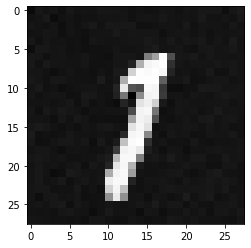

In [7]:
index = torch.randint(0, n, (1,))[0]
sample = samples[index]
starting_noise = original_noise[index]
plt.imshow(sample[0].cpu(), cmap="gray")
plt.show()

In [5]:
n_samples = 1
torch.manual_seed(torch.LongTensor([306]))
with torch.no_grad():
    result = model.sample(n_samples, (1, 28, 28), starting_noise=starting_noise[None, ...].repeat((n_samples, 1, 1, 1)), device=device, return_at_step=-1)
result_normalized = (result - result.min()) / (result.max() - result.min())



torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


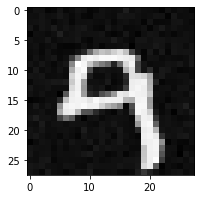

In [37]:
# Plot the four samples
fig, axs = plt.subplots(1, n_samples, figsize=(n_samples * 3, 6))
for i in range(n_samples):
    curr_axs = axs if n_samples == 1 else axs[i]
    curr_axs.imshow(result_normalized[i, 0].cpu(), cmap="gray")
plt.show()


In [8]:
def sample_extended(m: DDPM, n_sample, size, device, use_z=True) -> torch.Tensor:
    x_i = torch.randn(n_sample, *size).to(device)
    for i in range(m.n_T, 0, -1):
        z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
        eps = m.eps_model(x_i, i / m.n_T)
        x_i = (m.oneover_sqrta[i] * (x_i - eps * m.mab_over_sqrtmab[i]))
        if use_z:
            x_i += m.sqrt_beta_t[i] * z
    return x_i    
    

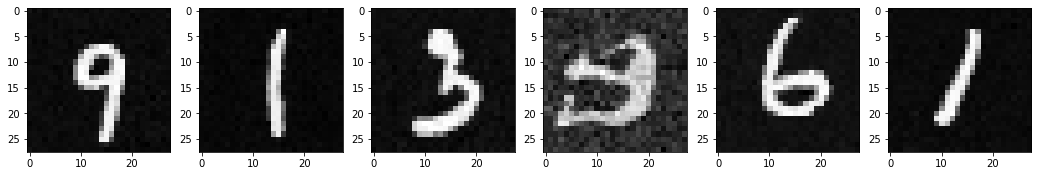

In [9]:
# With z
n = 6
with torch.no_grad():
    result = sample_extended(model, n, (1, 28, 28), device=device, use_z=True)
result_normalized = (result - result.min()) / (result.max() - result.min())
plot_samples(result_normalized)

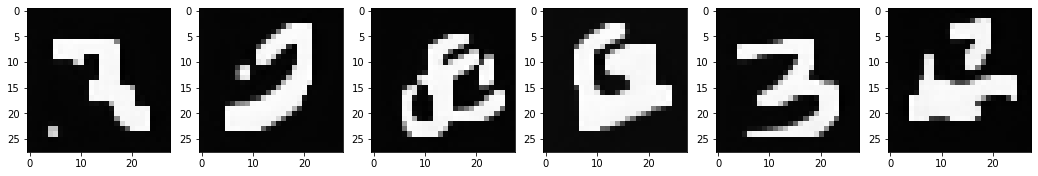

In [11]:
# No z
n = 6
with torch.no_grad():
    result = sample_extended(model, n, (1, 28, 28), device=device, use_z=False)
result_normalized = (result - result.min()) / (result.max() - result.min())
plot_samples(result_normalized)